# Chapter06 ゲート付きRNN

---

## 前準備

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from common.np import *
from common.base_model import BaseModel
from common.functions import sigmoid
from common.time_layers import *
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

from common import config
from common.util import to_gpu
# GPUで実行しない場合は下記をコメントアウト
config.GPU = True

## RNNの問題点

- RNNは時系列データの長期の依存関係を学習することが苦手
  - BPTT(Backpropagation Through Time)が勾配消失もしくは勾配爆発を起こすため
    - 勾配消失の原因: $y = \tanh(x)$の微分$\frac{\partial y}{\partial x} = 1 - y^2$となり, 時間を経る度に1より小さい数が乗算される
    - 勾配爆発の原因: MatMulを通るたびに重みをT回乗算するために起こる

- 勾配爆発は勾配クリッピングによって対策が出来る(以下は擬似コード)
  - $\|\hat{g}\|$が$threshold$を超えた場合に勾配の修正を行うというもの
$$
\mathrm{if} \quad \|\hat{g}\| \geq threshold: \\
\hat{g} = \dfrac{threshold}{\|\hat{g}\|}\hat{g}
$$

- $threshold$: 閾値
$\hat{g}$: NNで使用される全てのパラメータの勾配を一つにまとめたもの

In [2]:
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

## 勾配消失とLSTM

- 勾配消失問題を解決するにはアーキテクチャを根本から変える必要がある
  - その1つがゲート付きRNN
    - 代表的手法にLSTMとGRUがあるが, 本章ではLSTMに焦点を当てる
    
- RNNとLSTMの違いとしてLSTMには記憶セルが存在する
  - この記憶セルはLSTMレイヤ内で完結するため他のレイヤへ出力しない
  - 現在の記憶セル$c_t$は3つの入力($c_{t-1}, h_{t_1}, x_t$)から後述していく計算によって求められる
  - 更新された$c_t$を使用して隠れ状態$h_t$が計算される
    - この計算は$h_t = \tanh(c_t)$によって$c_t$の各要素に対し$\tanh$関数を適用する

- LSTMにはゲートという機能がある
  - データの流れをコントロールする
  - 「output」「forget」「input」の3種類のゲートが存在する

---

- 入力データに対し, ゲートは以下の順で動作を行い, $h_t$を出力する
  - forgetゲート: 記憶セル$c_{t-1}$に対し何を忘れるかを指示するゲート
    - このままでは忘れただけで新しい情報$\mathrm{g}$を記憶セルに追加する
  - inputゲート: $\mathrm{g}$の各要素が新たに追加する情報としてどれだけ価値があるかを判断する(追加情報の取捨選択)
  - outputゲート: $\tanh(c_t)$の各要素に対し, 「それらが次時刻の隠れ状態としてどれだけ重要か」を調整するゲート

- 上記の4工程を式に表すと以下となる
  - forgetゲート: $\mathrm{f} = \sigma(x_t W_x^{(\mathrm{f})} + h_{t-1}W_h^{(\mathrm{f})} + b^{(\mathrm{f})})$
  - 情報の追加: $\mathrm{g} = \tanh(x_t W_x^{(\mathbf{g})} + h_{t-1}W_h^{(\mathbf{g})} + b^{(\mathrm{g})})$
  - inputゲート: $\mathrm{i} = \sigma(x_t W_x^{(\mathrm{i})} + h_{t-1}W_h^{(\mathrm{i})} + b^{(\mathrm{i})})$
  - outputゲート: $\mathrm{o} = \sigma(x_t W_x^{(\mathrm{o})} + h_{t-1}W_h^{(\mathrm{o})} + b^{(\mathrm{o})})$
  
- forgetゲート, 追加情報, inputゲートの3つの出力と前の時刻の記憶セル$c_{t-1}$によって現時刻の記憶セル$c_t$を求められる
  - $c_t = \mathrm{f} \odot c_{t-1} + \mathrm{g} \odot \mathrm{i}$
- outputゲートの出力$\mathrm{o}$に対し$\tanh(c_t)$とのアダマール積を計算し$h_t$を求める事ができる
  - $h_t = \mathrm{o} \odot \tanh(c_t)$
- RNNの逆伝播では同じ重みと行列を使用した「行列の積」を繰り返し行っていたが, LSTMの逆伝播では「要素ごとの積」を毎時刻, 異なるゲート値によって行うため勾配消失が起こりにくい

---

## LSTMの実装

- forget ~ outputまでの4つの式はいずれも関数内で$xW_x+hW_h+b$の形状をとっている為, 以下のような計算を行ったほうが計算を高速化することができる
$$
x_t[W_x^{(\mathrm{f})} \quad W_x^{(\mathrm{g})} \quad W_x^{(\mathrm{i})} \quad W_x^{(\mathrm{o})}] + h_{t-1}[W_h^{(\mathrm{f})} \quad W_h^{(\mathrm{g})} \quad W_h^{(\mathrm{i})} \quad W_h^{(\mathrm{o})}] + [b^{(\mathrm{f})} \quad b^{(\mathrm{g})} \quad b^{(\mathrm{i})} \quad b^{(\mathrm{o})}] \\
= x_tW_x + h_{t-1}W_h + b
$$

In [3]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        # Wx, Wh, bには4つ分の重み, バイアスがまとめられている
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H: 3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
        dc_prev = ds * f
        
        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i
        
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= g * (1 - g ** 2)
        
        dA = np.hstack((df, dg, di, do))
        
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)
        return dx, dh_prev, dc_prev

---

### TimeLSTMの実装

- T個分の時系列データをまとめて処理するレイヤ
  - T個のLSTMレイヤによって構成される
  
 - Truncated BPTTは逆伝播のつながりを適当な長さで断ち切り, 順伝播の流れは維持する必要がある
   - なので隠れ状態と記憶セルをメンバ変数に保持させるようにすることで次のforward()が呼ばれた際に, 前時刻の隠れ状態と記憶セルから開始することができる

In [4]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

---

## LSTMを使った言語モデル

- 前章のTimeRNNレイヤの場所にTimeLSTMレイヤを使用する
  - ネットワーク構成に関してはChpter05.ipynbを参照

In [5]:
class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # 全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    # 7章で使用するメソッド
    # 本章では使用しないため不要だが一応掲載
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
    
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f) 

---

### PTBデータセットの学習

- 前章と異なりPTBデータセットの訓練データすべてを使って学習をする

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 10000.57
| epoch 1 |  iter 21 / 1327 | time 7[s] | perplexity 2333.09
| epoch 1 |  iter 41 / 1327 | time 14[s] | perplexity 1302.65
| epoch 1 |  iter 61 / 1327 | time 21[s] | perplexity 1099.69
| epoch 1 |  iter 81 / 1327 | time 28[s] | perplexity 958.64
| epoch 1 |  iter 101 / 1327 | time 35[s] | perplexity 837.38
| epoch 1 |  iter 121 / 1327 | time 42[s] | perplexity 833.66
| epoch 1 |  iter 141 / 1327 | time 49[s] | perplexity 789.58
| epoch 1 |  iter 161 / 1327 | time 56[s] | perplexity 707.46
| epoch 1 |  iter 181 / 1327 | time 63[s] | perplexity 709.23
| epoch 1 |  iter 201 / 1327 | time 70[s] | perplexity 625.92
| epoch 1 |  iter 221 / 1327 | time 77[s] | perplexity 606.73
| epoch 1 |  iter 241 / 1327 | time 84[s] | perplexity 544.74
| epoch 1 |  iter 261 / 1327 | time 91[s] | perplexity 577.84
| epoch 1 |  iter 281 / 1327 | time 98[s] | perplexity 547.05
| epoch 1 |  iter 301 / 1327 | time 105[s] | perplexity 487.14
| epoch 1 

| epoch 2 |  iter 1261 / 1327 | time 907[s] | perplexity 167.83
| epoch 2 |  iter 1281 / 1327 | time 914[s] | perplexity 168.60
| epoch 2 |  iter 1301 / 1327 | time 921[s] | perplexity 210.62
| epoch 2 |  iter 1321 / 1327 | time 929[s] | perplexity 202.01
| epoch 3 |  iter 1 / 1327 | time 931[s] | perplexity 214.90
| epoch 3 |  iter 21 / 1327 | time 938[s] | perplexity 200.21
| epoch 3 |  iter 41 / 1327 | time 945[s] | perplexity 188.94
| epoch 3 |  iter 61 / 1327 | time 952[s] | perplexity 174.09
| epoch 3 |  iter 81 / 1327 | time 959[s] | perplexity 159.34
| epoch 3 |  iter 101 / 1327 | time 966[s] | perplexity 146.68
| epoch 3 |  iter 121 / 1327 | time 973[s] | perplexity 160.15
| epoch 3 |  iter 141 / 1327 | time 980[s] | perplexity 171.15
| epoch 3 |  iter 161 / 1327 | time 987[s] | perplexity 190.90
| epoch 3 |  iter 181 / 1327 | time 995[s] | perplexity 201.86
| epoch 3 |  iter 201 / 1327 | time 1002[s] | perplexity 190.68
| epoch 3 |  iter 221 / 1327 | time 1009[s] | perplexity

| epoch 4 |  iter 1141 / 1327 | time 1812[s] | perplexity 134.92
| epoch 4 |  iter 1161 / 1327 | time 1819[s] | perplexity 127.48
| epoch 4 |  iter 1181 / 1327 | time 1826[s] | perplexity 127.70
| epoch 4 |  iter 1201 / 1327 | time 1833[s] | perplexity 113.46
| epoch 4 |  iter 1221 / 1327 | time 1840[s] | perplexity 101.33
| epoch 4 |  iter 1241 / 1327 | time 1847[s] | perplexity 126.34
| epoch 4 |  iter 1261 / 1327 | time 1854[s] | perplexity 124.97
| epoch 4 |  iter 1281 / 1327 | time 1861[s] | perplexity 121.14
| epoch 4 |  iter 1301 / 1327 | time 1869[s] | perplexity 149.47
| epoch 4 |  iter 1321 / 1327 | time 1876[s] | perplexity 147.44


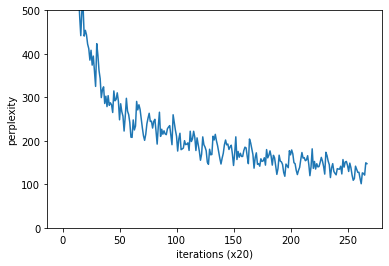

evaluating perplexity ...
234 / 235
test perplexity:  153.9599240830437


In [33]:
# ハイパーパラメータ
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータで取得
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# パラメータの保存
model.save_params()

- <code>RnnlmTrainer</code>クラスによる学習
  - <code>fit()</code>メソッドでモデルの勾配を求め, モデルのパラメータを更新する
  - 引数<code>max_grad</code>の指定によって勾配クリッピングが適用される
  
---

## RNNLMのさらなる改善

1. LSTMレイヤの多層化
  - ここまでは1層のLSTMレイヤだが複数層重ねることで精度向上が期待できる
  - 適切な層数に関してはハイパーパラメータであるため取り組む問題の難解さ等で異なってくる
    - 参考までにPTBデータセットにおいては2~4程度が良い
2. Dropoutによる過学習の抑制
  - 画像認識等に用いられるようなCNN同様ランダムにニューロンを選び, そのニューロンを無視する
  - 差し込むには時間軸方向ではなく深さ方向に行うべき
    - 時間軸方向に差し込むと時間の進行と比例してDropoutによるノイズが蓄積するため
3. 重み共有
  - EmbeddingレイヤとAffineレイヤの重みを共有するテクニック
    - 学習パラメータの削減と精度向上が期待できる
    - 語彙数$V$, LSTMの隠れ状態の次元数を$H$とした時, Embedding, Affineのそれぞれのレイヤの重み形状は$(V \times H), (H \times V)$となる
      - なのでEmbeddingレイヤの重みの転置をAffineレイヤに適用することで共有が可能となる


- 上記の改善点を踏まえて実装を行う

In [6]:
class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4*H).astype('f')
        lstm_Wx2 = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4*H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 改善
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),  # Dropout層の追加
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),  # LSTMレイヤの追加
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b) # 重み共有
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def predict(self, xs, train_fig=False):
        for layer in self.drop_layers:
            layer.train_fig = train_fig
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

---

### 学習

In [7]:
# ハイパーパラメータ
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')


if config.GPU:
    print("use GPU")
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

print('start')
# モデルの生成
model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size, time_size=time_size, max_grad=max_grad)
    
    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)
    
    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr
        
    model.reset_state()
    print('-' * 50)


# テストデータでの評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

use GPU
start
| epoch 1 |  iter 1 / 1327 | time 2[s] | perplexity 9999.64
| epoch 1 |  iter 21 / 1327 | time 57[s] | perplexity 2332.98
| epoch 1 |  iter 41 / 1327 | time 112[s] | perplexity 1302.69
| epoch 1 |  iter 61 / 1327 | time 166[s] | perplexity 1102.01
| epoch 1 |  iter 81 / 1327 | time 219[s] | perplexity 973.97
| epoch 1 |  iter 101 / 1327 | time 272[s] | perplexity 886.08
| epoch 1 |  iter 121 / 1327 | time 324[s] | perplexity 884.47
| epoch 1 |  iter 141 / 1327 | time 376[s] | perplexity 855.37
| epoch 1 |  iter 161 / 1327 | time 429[s] | perplexity 823.06
| epoch 1 |  iter 181 / 1327 | time 481[s] | perplexity 837.94
| epoch 1 |  iter 201 / 1327 | time 533[s] | perplexity 783.12
| epoch 1 |  iter 221 / 1327 | time 585[s] | perplexity 795.23
| epoch 1 |  iter 241 / 1327 | time 637[s] | perplexity 750.69
| epoch 1 |  iter 261 / 1327 | time 690[s] | perplexity 803.15
| epoch 1 |  iter 281 / 1327 | time 742[s] | perplexity 783.73
| epoch 1 |  iter 301 / 1327 | time 794[s] | p

| epoch 2 |  iter 1201 / 1327 | time 3151[s] | perplexity 211.27
| epoch 2 |  iter 1221 / 1327 | time 3205[s] | perplexity 209.41
| epoch 2 |  iter 1241 / 1327 | time 3259[s] | perplexity 244.48
| epoch 2 |  iter 1261 / 1327 | time 3314[s] | perplexity 226.27
| epoch 2 |  iter 1281 / 1327 | time 3368[s] | perplexity 231.69
| epoch 2 |  iter 1301 / 1327 | time 3421[s] | perplexity 287.87
| epoch 2 |  iter 1321 / 1327 | time 3475[s] | perplexity 266.01
evaluating perplexity ...
209 / 210
valid perplexity:  262.9418275811163
--------------------------------------------------
| epoch 3 |  iter 1 / 1327 | time 2[s] | perplexity 344.71
| epoch 3 |  iter 21 / 1327 | time 56[s] | perplexity 264.78
| epoch 3 |  iter 41 / 1327 | time 110[s] | perplexity 251.20
| epoch 3 |  iter 61 / 1327 | time 164[s] | perplexity 232.33
| epoch 3 |  iter 81 / 1327 | time 217[s] | perplexity 216.22
| epoch 3 |  iter 101 / 1327 | time 270[s] | perplexity 202.16
| epoch 3 |  iter 121 / 1327 | time 324[s] | perplex

| epoch 4 |  iter 1021 / 1327 | time 2729[s] | perplexity 197.33
| epoch 4 |  iter 1041 / 1327 | time 2783[s] | perplexity 180.12
| epoch 4 |  iter 1061 / 1327 | time 2836[s] | perplexity 171.30
| epoch 4 |  iter 1081 / 1327 | time 2889[s] | perplexity 145.33
| epoch 4 |  iter 1101 / 1327 | time 2941[s] | perplexity 162.70
| epoch 4 |  iter 1121 / 1327 | time 2994[s] | perplexity 198.78
| epoch 4 |  iter 1141 / 1327 | time 3047[s] | perplexity 186.46
| epoch 4 |  iter 1161 / 1327 | time 3099[s] | perplexity 172.03
| epoch 4 |  iter 1181 / 1327 | time 3153[s] | perplexity 170.09
| epoch 4 |  iter 1201 / 1327 | time 3208[s] | perplexity 146.45
| epoch 4 |  iter 1221 / 1327 | time 3269[s] | perplexity 144.72
| epoch 4 |  iter 1241 / 1327 | time 3326[s] | perplexity 172.18
| epoch 4 |  iter 1261 / 1327 | time 3380[s] | perplexity 157.98
| epoch 4 |  iter 1281 / 1327 | time 3434[s] | perplexity 164.13
| epoch 4 |  iter 1301 / 1327 | time 3488[s] | perplexity 207.34
| epoch 4 |  iter 1321 / 

| epoch 6 |  iter 841 / 1327 | time 2416[s] | perplexity 149.49
| epoch 6 |  iter 861 / 1327 | time 2470[s] | perplexity 145.12
| epoch 6 |  iter 881 / 1327 | time 2524[s] | perplexity 134.72
| epoch 6 |  iter 901 / 1327 | time 2578[s] | perplexity 178.05
| epoch 6 |  iter 921 / 1327 | time 2632[s] | perplexity 155.35
| epoch 6 |  iter 941 / 1327 | time 2687[s] | perplexity 159.10
| epoch 6 |  iter 961 / 1327 | time 2741[s] | perplexity 171.20
| epoch 6 |  iter 981 / 1327 | time 2795[s] | perplexity 161.09
| epoch 6 |  iter 1001 / 1327 | time 2849[s] | perplexity 137.95
| epoch 6 |  iter 1021 / 1327 | time 2903[s] | perplexity 163.63
| epoch 6 |  iter 1041 / 1327 | time 2958[s] | perplexity 148.57
| epoch 6 |  iter 1061 / 1327 | time 3012[s] | perplexity 136.86
| epoch 6 |  iter 1081 / 1327 | time 3066[s] | perplexity 117.08
| epoch 6 |  iter 1101 / 1327 | time 3120[s] | perplexity 124.60
| epoch 6 |  iter 1121 / 1327 | time 3174[s] | perplexity 161.68
| epoch 6 |  iter 1141 / 1327 | t

| epoch 8 |  iter 661 / 1327 | time 2372[s] | perplexity 130.58
| epoch 8 |  iter 681 / 1327 | time 2439[s] | perplexity 113.60
| epoch 8 |  iter 701 / 1327 | time 2506[s] | perplexity 131.92
| epoch 8 |  iter 721 / 1327 | time 2574[s] | perplexity 135.00
| epoch 8 |  iter 741 / 1327 | time 2643[s] | perplexity 116.90
| epoch 8 |  iter 761 / 1327 | time 2709[s] | perplexity 109.72
| epoch 8 |  iter 781 / 1327 | time 2777[s] | perplexity 117.70
| epoch 8 |  iter 801 / 1327 | time 2845[s] | perplexity 133.45
| epoch 8 |  iter 821 / 1327 | time 2911[s] | perplexity 129.20
| epoch 8 |  iter 841 / 1327 | time 2977[s] | perplexity 129.71
| epoch 8 |  iter 861 / 1327 | time 3042[s] | perplexity 126.96
| epoch 8 |  iter 881 / 1327 | time 3110[s] | perplexity 116.60
| epoch 8 |  iter 901 / 1327 | time 3186[s] | perplexity 153.22
| epoch 8 |  iter 921 / 1327 | time 3335[s] | perplexity 134.14
| epoch 8 |  iter 941 / 1327 | time 3407[s] | perplexity 140.25
| epoch 8 |  iter 961 / 1327 | time 3473

| epoch 10 |  iter 481 / 1327 | time 1516[s] | perplexity 106.60
| epoch 10 |  iter 501 / 1327 | time 1579[s] | perplexity 119.18
| epoch 10 |  iter 521 / 1327 | time 1641[s] | perplexity 119.39
| epoch 10 |  iter 541 / 1327 | time 1704[s] | perplexity 122.16
| epoch 10 |  iter 561 / 1327 | time 1767[s] | perplexity 103.18
| epoch 10 |  iter 581 / 1327 | time 1830[s] | perplexity 95.04
| epoch 10 |  iter 601 / 1327 | time 1893[s] | perplexity 134.95
| epoch 10 |  iter 621 / 1327 | time 1955[s] | perplexity 127.17
| epoch 10 |  iter 641 / 1327 | time 2017[s] | perplexity 113.30
| epoch 10 |  iter 661 / 1327 | time 2080[s] | perplexity 105.22
| epoch 10 |  iter 681 / 1327 | time 2143[s] | perplexity 92.03
| epoch 10 |  iter 701 / 1327 | time 2206[s] | perplexity 108.04
| epoch 10 |  iter 721 / 1327 | time 2269[s] | perplexity 110.42
| epoch 10 |  iter 741 / 1327 | time 2333[s] | perplexity 94.20
| epoch 10 |  iter 761 / 1327 | time 2396[s] | perplexity 88.34
| epoch 10 |  iter 781 / 1327

| epoch 12 |  iter 281 / 1327 | time 839[s] | perplexity 117.31
| epoch 12 |  iter 301 / 1327 | time 898[s] | perplexity 100.45
| epoch 12 |  iter 321 / 1327 | time 958[s] | perplexity 79.91
| epoch 12 |  iter 341 / 1327 | time 1018[s] | perplexity 111.23
| epoch 12 |  iter 361 / 1327 | time 1078[s] | perplexity 117.37
| epoch 12 |  iter 381 / 1327 | time 1137[s] | perplexity 97.94
| epoch 12 |  iter 401 / 1327 | time 1197[s] | perplexity 113.36
| epoch 12 |  iter 421 / 1327 | time 1259[s] | perplexity 98.59
| epoch 12 |  iter 441 / 1327 | time 1321[s] | perplexity 102.83
| epoch 12 |  iter 461 / 1327 | time 1381[s] | perplexity 102.08
| epoch 12 |  iter 481 / 1327 | time 1441[s] | perplexity 100.86
| epoch 12 |  iter 501 / 1327 | time 1501[s] | perplexity 113.91
| epoch 12 |  iter 521 / 1327 | time 1560[s] | perplexity 114.61
| epoch 12 |  iter 541 / 1327 | time 1620[s] | perplexity 119.53
| epoch 12 |  iter 561 / 1327 | time 1680[s] | perplexity 100.45
| epoch 12 |  iter 581 / 1327 |

| epoch 14 |  iter 81 / 1327 | time 242[s] | perplexity 86.41
| epoch 14 |  iter 101 / 1327 | time 302[s] | perplexity 84.96
| epoch 14 |  iter 121 / 1327 | time 362[s] | perplexity 90.41
| epoch 14 |  iter 141 / 1327 | time 422[s] | perplexity 98.04
| epoch 14 |  iter 161 / 1327 | time 481[s] | perplexity 113.54
| epoch 14 |  iter 181 / 1327 | time 541[s] | perplexity 117.62
| epoch 14 |  iter 201 / 1327 | time 600[s] | perplexity 114.35
| epoch 14 |  iter 221 / 1327 | time 660[s] | perplexity 111.90
| epoch 14 |  iter 241 / 1327 | time 719[s] | perplexity 106.40
| epoch 14 |  iter 261 / 1327 | time 778[s] | perplexity 117.64
| epoch 14 |  iter 281 / 1327 | time 838[s] | perplexity 113.76
| epoch 14 |  iter 301 / 1327 | time 898[s] | perplexity 94.31
| epoch 14 |  iter 321 / 1327 | time 958[s] | perplexity 77.53
| epoch 14 |  iter 341 / 1327 | time 1017[s] | perplexity 106.60
| epoch 14 |  iter 361 / 1327 | time 1077[s] | perplexity 113.84
| epoch 14 |  iter 381 / 1327 | time 1137[s] 

| epoch 15 |  iter 1261 / 1327 | time 3763[s] | perplexity 87.01
| epoch 15 |  iter 1281 / 1327 | time 3822[s] | perplexity 86.64
| epoch 15 |  iter 1301 / 1327 | time 3882[s] | perplexity 112.93
| epoch 15 |  iter 1321 / 1327 | time 3941[s] | perplexity 111.41
evaluating perplexity ...
209 / 210
valid perplexity:  139.82060160981118
--------------------------------------------------
| epoch 16 |  iter 1 / 1327 | time 2[s] | perplexity 176.35
| epoch 16 |  iter 21 / 1327 | time 62[s] | perplexity 103.58
| epoch 16 |  iter 41 / 1327 | time 121[s] | perplexity 99.62
| epoch 16 |  iter 61 / 1327 | time 181[s] | perplexity 95.21
| epoch 16 |  iter 81 / 1327 | time 240[s] | perplexity 84.14
| epoch 16 |  iter 101 / 1327 | time 300[s] | perplexity 82.32
| epoch 16 |  iter 121 / 1327 | time 360[s] | perplexity 87.42
| epoch 16 |  iter 141 / 1327 | time 419[s] | perplexity 93.35
| epoch 16 |  iter 161 / 1327 | time 479[s] | perplexity 107.91
| epoch 16 |  iter 181 / 1327 | time 539[s] | perple

| epoch 17 |  iter 1061 / 1327 | time 3161[s] | perplexity 87.34
| epoch 17 |  iter 1081 / 1327 | time 3221[s] | perplexity 72.00
| epoch 17 |  iter 1101 / 1327 | time 3281[s] | perplexity 75.06
| epoch 17 |  iter 1121 / 1327 | time 3341[s] | perplexity 102.18
| epoch 17 |  iter 1141 / 1327 | time 3400[s] | perplexity 96.44
| epoch 17 |  iter 1161 / 1327 | time 3460[s] | perplexity 84.05
| epoch 17 |  iter 1181 / 1327 | time 3520[s] | perplexity 90.64
| epoch 17 |  iter 1201 / 1327 | time 3580[s] | perplexity 74.48
| epoch 17 |  iter 1221 / 1327 | time 3639[s] | perplexity 75.08
| epoch 17 |  iter 1241 / 1327 | time 3699[s] | perplexity 89.38
| epoch 17 |  iter 1261 / 1327 | time 3759[s] | perplexity 85.57
| epoch 17 |  iter 1281 / 1327 | time 3818[s] | perplexity 85.42
| epoch 17 |  iter 1301 / 1327 | time 3878[s] | perplexity 109.58
| epoch 17 |  iter 1321 / 1327 | time 3937[s] | perplexity 106.10
evaluating perplexity ...
209 / 210
valid perplexity:  137.74324250962871
-------------

| epoch 19 |  iter 861 / 1327 | time 2702[s] | perplexity 93.07
| epoch 19 |  iter 881 / 1327 | time 2774[s] | perplexity 83.91
| epoch 19 |  iter 901 / 1327 | time 2840[s] | perplexity 107.49
| epoch 19 |  iter 921 / 1327 | time 2906[s] | perplexity 94.70
| epoch 19 |  iter 941 / 1327 | time 2973[s] | perplexity 99.90
| epoch 19 |  iter 961 / 1327 | time 3040[s] | perplexity 107.07
| epoch 19 |  iter 981 / 1327 | time 3107[s] | perplexity 100.73
| epoch 19 |  iter 1001 / 1327 | time 3229[s] | perplexity 87.60
| epoch 19 |  iter 1021 / 1327 | time 3298[s] | perplexity 104.13
| epoch 19 |  iter 1041 / 1327 | time 3366[s] | perplexity 91.26
| epoch 19 |  iter 1061 / 1327 | time 3434[s] | perplexity 86.30
| epoch 19 |  iter 1081 / 1327 | time 3502[s] | perplexity 70.78
| epoch 19 |  iter 1101 / 1327 | time 3569[s] | perplexity 74.86
| epoch 19 |  iter 1121 / 1327 | time 3638[s] | perplexity 100.49
| epoch 19 |  iter 1141 / 1327 | time 3704[s] | perplexity 97.64
| epoch 19 |  iter 1161 / 1

| epoch 21 |  iter 661 / 1327 | time 2145[s] | perplexity 91.07
| epoch 21 |  iter 681 / 1327 | time 2199[s] | perplexity 79.55
| epoch 21 |  iter 701 / 1327 | time 2253[s] | perplexity 94.09
| epoch 21 |  iter 721 / 1327 | time 2307[s] | perplexity 94.94
| epoch 21 |  iter 741 / 1327 | time 2361[s] | perplexity 82.45
| epoch 21 |  iter 761 / 1327 | time 2414[s] | perplexity 76.08
| epoch 21 |  iter 781 / 1327 | time 2468[s] | perplexity 83.00
| epoch 21 |  iter 801 / 1327 | time 2522[s] | perplexity 93.66
| epoch 21 |  iter 821 / 1327 | time 2576[s] | perplexity 93.19
| epoch 21 |  iter 841 / 1327 | time 2630[s] | perplexity 91.24
| epoch 21 |  iter 861 / 1327 | time 2683[s] | perplexity 92.50
| epoch 21 |  iter 881 / 1327 | time 2737[s] | perplexity 83.91
| epoch 21 |  iter 901 / 1327 | time 2791[s] | perplexity 106.56
| epoch 21 |  iter 921 / 1327 | time 2845[s] | perplexity 95.08
| epoch 21 |  iter 941 / 1327 | time 2899[s] | perplexity 101.29
| epoch 21 |  iter 961 / 1327 | time 2

| epoch 23 |  iter 461 / 1327 | time 1286[s] | perplexity 91.22
| epoch 23 |  iter 481 / 1327 | time 1340[s] | perplexity 91.07
| epoch 23 |  iter 501 / 1327 | time 1394[s] | perplexity 101.36
| epoch 23 |  iter 521 / 1327 | time 1450[s] | perplexity 101.15
| epoch 23 |  iter 541 / 1327 | time 1504[s] | perplexity 106.00
| epoch 23 |  iter 561 / 1327 | time 1559[s] | perplexity 88.66
| epoch 23 |  iter 581 / 1327 | time 1614[s] | perplexity 83.18
| epoch 23 |  iter 601 / 1327 | time 1669[s] | perplexity 117.37
| epoch 23 |  iter 621 / 1327 | time 1725[s] | perplexity 108.71
| epoch 23 |  iter 641 / 1327 | time 1781[s] | perplexity 99.40
| epoch 23 |  iter 661 / 1327 | time 1838[s] | perplexity 92.33
| epoch 23 |  iter 681 / 1327 | time 1893[s] | perplexity 80.68
| epoch 23 |  iter 701 / 1327 | time 1950[s] | perplexity 93.77
| epoch 23 |  iter 721 / 1327 | time 2005[s] | perplexity 95.46
| epoch 23 |  iter 741 / 1327 | time 2064[s] | perplexity 81.87
| epoch 23 |  iter 761 / 1327 | tim

| epoch 25 |  iter 261 / 1327 | time 701[s] | perplexity 109.30
| epoch 25 |  iter 281 / 1327 | time 755[s] | perplexity 104.97
| epoch 25 |  iter 301 / 1327 | time 809[s] | perplexity 88.22
| epoch 25 |  iter 321 / 1327 | time 863[s] | perplexity 70.60
| epoch 25 |  iter 341 / 1327 | time 917[s] | perplexity 98.69
| epoch 25 |  iter 361 / 1327 | time 970[s] | perplexity 106.42
| epoch 25 |  iter 381 / 1327 | time 1024[s] | perplexity 86.58
| epoch 25 |  iter 401 / 1327 | time 1078[s] | perplexity 99.96
| epoch 25 |  iter 421 / 1327 | time 1132[s] | perplexity 88.29
| epoch 25 |  iter 441 / 1327 | time 1185[s] | perplexity 91.71
| epoch 25 |  iter 461 / 1327 | time 1239[s] | perplexity 90.11
| epoch 25 |  iter 481 / 1327 | time 1293[s] | perplexity 91.13
| epoch 25 |  iter 501 / 1327 | time 1346[s] | perplexity 101.54
| epoch 25 |  iter 521 / 1327 | time 1400[s] | perplexity 101.62
| epoch 25 |  iter 541 / 1327 | time 1454[s] | perplexity 106.11
| epoch 25 |  iter 561 / 1327 | time 150

| epoch 27 |  iter 61 / 1327 | time 195[s] | perplexity 92.10
| epoch 27 |  iter 81 / 1327 | time 259[s] | perplexity 81.49
| epoch 27 |  iter 101 / 1327 | time 323[s] | perplexity 79.91
| epoch 27 |  iter 121 / 1327 | time 387[s] | perplexity 84.81
| epoch 27 |  iter 141 / 1327 | time 451[s] | perplexity 90.00
| epoch 27 |  iter 161 / 1327 | time 515[s] | perplexity 104.65
| epoch 27 |  iter 181 / 1327 | time 579[s] | perplexity 108.21
| epoch 27 |  iter 201 / 1327 | time 643[s] | perplexity 107.87
| epoch 27 |  iter 221 / 1327 | time 708[s] | perplexity 104.49
| epoch 27 |  iter 241 / 1327 | time 773[s] | perplexity 100.10
| epoch 27 |  iter 261 / 1327 | time 838[s] | perplexity 108.00
| epoch 27 |  iter 281 / 1327 | time 902[s] | perplexity 104.26
| epoch 27 |  iter 301 / 1327 | time 966[s] | perplexity 87.55
| epoch 27 |  iter 321 / 1327 | time 1031[s] | perplexity 70.93
| epoch 27 |  iter 341 / 1327 | time 1095[s] | perplexity 99.00
| epoch 27 |  iter 361 / 1327 | time 1159[s] | p

| epoch 28 |  iter 1241 / 1327 | time 4696[s] | perplexity 86.25
| epoch 28 |  iter 1261 / 1327 | time 4769[s] | perplexity 79.62
| epoch 28 |  iter 1281 / 1327 | time 4834[s] | perplexity 80.93
| epoch 28 |  iter 1301 / 1327 | time 4898[s] | perplexity 103.20
| epoch 28 |  iter 1321 / 1327 | time 4960[s] | perplexity 99.84
evaluating perplexity ...
209 / 210
valid perplexity:  135.46829083988186
--------------------------------------------------
| epoch 29 |  iter 1 / 1327 | time 3[s] | perplexity 176.52
| epoch 29 |  iter 21 / 1327 | time 71[s] | perplexity 98.55
| epoch 29 |  iter 41 / 1327 | time 137[s] | perplexity 95.97
| epoch 29 |  iter 61 / 1327 | time 201[s] | perplexity 91.55
| epoch 29 |  iter 81 / 1327 | time 265[s] | perplexity 81.13
| epoch 29 |  iter 101 / 1327 | time 328[s] | perplexity 79.62
| epoch 29 |  iter 121 / 1327 | time 392[s] | perplexity 85.09
| epoch 29 |  iter 141 / 1327 | time 455[s] | perplexity 91.46
| epoch 29 |  iter 161 / 1327 | time 519[s] | perplex

| epoch 30 |  iter 1041 / 1327 | time 3524[s] | perplexity 89.03
| epoch 30 |  iter 1061 / 1327 | time 3595[s] | perplexity 83.45
| epoch 30 |  iter 1081 / 1327 | time 3669[s] | perplexity 69.93
| epoch 30 |  iter 1101 / 1327 | time 3745[s] | perplexity 73.30
| epoch 30 |  iter 1121 / 1327 | time 3815[s] | perplexity 98.34
| epoch 30 |  iter 1141 / 1327 | time 3888[s] | perplexity 93.68
| epoch 30 |  iter 1161 / 1327 | time 3960[s] | perplexity 81.29
| epoch 30 |  iter 1181 / 1327 | time 4028[s] | perplexity 85.79
| epoch 30 |  iter 1201 / 1327 | time 4096[s] | perplexity 72.92
| epoch 30 |  iter 1221 / 1327 | time 4163[s] | perplexity 72.07
| epoch 30 |  iter 1241 / 1327 | time 4233[s] | perplexity 84.69
| epoch 30 |  iter 1261 / 1327 | time 4303[s] | perplexity 80.68
| epoch 30 |  iter 1281 / 1327 | time 4373[s] | perplexity 80.27
| epoch 30 |  iter 1301 / 1327 | time 4447[s] | perplexity 102.16
| epoch 30 |  iter 1321 / 1327 | time 4519[s] | perplexity 99.99
evaluating perplexity ..

| epoch 32 |  iter 841 / 1327 | time 2533[s] | perplexity 91.63
| epoch 32 |  iter 861 / 1327 | time 2592[s] | perplexity 92.67
| epoch 32 |  iter 881 / 1327 | time 2652[s] | perplexity 82.64
| epoch 32 |  iter 901 / 1327 | time 2711[s] | perplexity 106.14
| epoch 32 |  iter 921 / 1327 | time 2771[s] | perplexity 95.07
| epoch 32 |  iter 941 / 1327 | time 2831[s] | perplexity 100.32
| epoch 32 |  iter 961 / 1327 | time 2890[s] | perplexity 109.07
| epoch 32 |  iter 981 / 1327 | time 2950[s] | perplexity 99.29
| epoch 32 |  iter 1001 / 1327 | time 3010[s] | perplexity 85.55
| epoch 32 |  iter 1021 / 1327 | time 3070[s] | perplexity 101.87
| epoch 32 |  iter 1041 / 1327 | time 3130[s] | perplexity 88.69
| epoch 32 |  iter 1061 / 1327 | time 3190[s] | perplexity 83.94
| epoch 32 |  iter 1081 / 1327 | time 3250[s] | perplexity 70.43
| epoch 32 |  iter 1101 / 1327 | time 3309[s] | perplexity 72.29
| epoch 32 |  iter 1121 / 1327 | time 3369[s] | perplexity 97.93
| epoch 32 |  iter 1141 / 132

| epoch 34 |  iter 641 / 1327 | time 1851[s] | perplexity 99.62
| epoch 34 |  iter 661 / 1327 | time 1909[s] | perplexity 90.32
| epoch 34 |  iter 681 / 1327 | time 1967[s] | perplexity 79.09
| epoch 34 |  iter 701 / 1327 | time 2025[s] | perplexity 93.30
| epoch 34 |  iter 721 / 1327 | time 2083[s] | perplexity 95.14
| epoch 34 |  iter 741 / 1327 | time 2141[s] | perplexity 81.77
| epoch 34 |  iter 761 / 1327 | time 2199[s] | perplexity 76.38
| epoch 34 |  iter 781 / 1327 | time 2256[s] | perplexity 82.54
| epoch 34 |  iter 801 / 1327 | time 2313[s] | perplexity 91.94
| epoch 34 |  iter 821 / 1327 | time 2371[s] | perplexity 91.29
| epoch 34 |  iter 841 / 1327 | time 2429[s] | perplexity 90.52
| epoch 34 |  iter 861 / 1327 | time 2486[s] | perplexity 92.44
| epoch 34 |  iter 881 / 1327 | time 2544[s] | perplexity 83.06
| epoch 34 |  iter 901 / 1327 | time 2601[s] | perplexity 106.13
| epoch 34 |  iter 921 / 1327 | time 2659[s] | perplexity 93.33
| epoch 34 |  iter 941 / 1327 | time 27

| epoch 36 |  iter 441 / 1327 | time 1273[s] | perplexity 91.58
| epoch 36 |  iter 461 / 1327 | time 1331[s] | perplexity 91.33
| epoch 36 |  iter 481 / 1327 | time 1389[s] | perplexity 91.11
| epoch 36 |  iter 501 / 1327 | time 1447[s] | perplexity 101.57
| epoch 36 |  iter 521 / 1327 | time 1504[s] | perplexity 101.40
| epoch 36 |  iter 541 / 1327 | time 1562[s] | perplexity 107.65
| epoch 36 |  iter 561 / 1327 | time 1620[s] | perplexity 89.48
| epoch 36 |  iter 581 / 1327 | time 1677[s] | perplexity 82.85
| epoch 36 |  iter 601 / 1327 | time 1735[s] | perplexity 116.17
| epoch 36 |  iter 621 / 1327 | time 1793[s] | perplexity 110.35
| epoch 36 |  iter 641 / 1327 | time 1851[s] | perplexity 98.99
| epoch 36 |  iter 661 / 1327 | time 1909[s] | perplexity 90.91
| epoch 36 |  iter 681 / 1327 | time 1967[s] | perplexity 80.92
| epoch 36 |  iter 701 / 1327 | time 2025[s] | perplexity 93.02
| epoch 36 |  iter 721 / 1327 | time 2084[s] | perplexity 94.71
| epoch 36 |  iter 741 / 1327 | tim

| epoch 38 |  iter 241 / 1327 | time 697[s] | perplexity 100.48
| epoch 38 |  iter 261 / 1327 | time 755[s] | perplexity 107.80
| epoch 38 |  iter 281 / 1327 | time 813[s] | perplexity 104.74
| epoch 38 |  iter 301 / 1327 | time 871[s] | perplexity 87.03
| epoch 38 |  iter 321 / 1327 | time 929[s] | perplexity 71.35
| epoch 38 |  iter 341 / 1327 | time 987[s] | perplexity 98.93
| epoch 38 |  iter 361 / 1327 | time 1045[s] | perplexity 105.67
| epoch 38 |  iter 381 / 1327 | time 1103[s] | perplexity 86.89
| epoch 38 |  iter 401 / 1327 | time 1161[s] | perplexity 102.52
| epoch 38 |  iter 421 / 1327 | time 1219[s] | perplexity 88.25
| epoch 38 |  iter 441 / 1327 | time 1276[s] | perplexity 90.58
| epoch 38 |  iter 461 / 1327 | time 1335[s] | perplexity 90.71
| epoch 38 |  iter 481 / 1327 | time 1393[s] | perplexity 90.54
| epoch 38 |  iter 501 / 1327 | time 1451[s] | perplexity 101.45
| epoch 38 |  iter 521 / 1327 | time 1509[s] | perplexity 101.58
| epoch 38 |  iter 541 / 1327 | time 15

| epoch 40 |  iter 41 / 1327 | time 118[s] | perplexity 94.54
| epoch 40 |  iter 61 / 1327 | time 176[s] | perplexity 91.15
| epoch 40 |  iter 81 / 1327 | time 234[s] | perplexity 80.82
| epoch 40 |  iter 101 / 1327 | time 292[s] | perplexity 78.55
| epoch 40 |  iter 121 / 1327 | time 350[s] | perplexity 85.20
| epoch 40 |  iter 141 / 1327 | time 408[s] | perplexity 91.97
| epoch 40 |  iter 161 / 1327 | time 466[s] | perplexity 105.58
| epoch 40 |  iter 181 / 1327 | time 524[s] | perplexity 108.96
| epoch 40 |  iter 201 / 1327 | time 582[s] | perplexity 108.46
| epoch 40 |  iter 221 / 1327 | time 640[s] | perplexity 104.56
| epoch 40 |  iter 241 / 1327 | time 697[s] | perplexity 98.03
| epoch 40 |  iter 261 / 1327 | time 756[s] | perplexity 109.06
| epoch 40 |  iter 281 / 1327 | time 814[s] | perplexity 105.53
| epoch 40 |  iter 301 / 1327 | time 872[s] | perplexity 87.85
| epoch 40 |  iter 321 / 1327 | time 930[s] | perplexity 71.23
| epoch 40 |  iter 341 / 1327 | time 988[s] | perple

---

### memo

- 改善したRNNLMのパープレキシティが本書程の数値にならなかった(何故（？）)
- GPUへの切り替えが上手くいってない
  - 要改善